## Content 

* [**About the Competition**](#1)
    * Objective of the Competition
    * About the kernel(Key Takeaways)
* [**Importing the necessary Packages**](#2)
* [**Exploratory Data Analysis**](#3)
    * Disease spread over the countries
    * Cases Confirmed Vs Fatalities across Countries
    * Forecasting Confirmed Cases and Fatality Rate
* [**Survival Probability and Hazard Rate**](#4)
* [**Inside Story of each Countries**](#5)
    * China
    * Italy
    * Iran
    * South Korea
* [**Observation and the big Question**](#6)
* [**References**](#8)
* [**Predicition**](#9)

## About the Competition:COVID19 Global Forecasting <a id="1"></a>

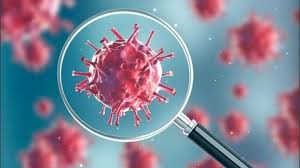

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.

The challenge involves forecasting confirmed cases and fatalities between March 25 and April 22 by region, the primary goal isn't to produce accurate forecasts. It’s to identify factors that appear to impact the transmission rate of COVID-19.

### About this kernel (Key TakeAways):

* Extensive EDA to understand more about the corona disease.
* Modeling tor forercast the future values.

With this we can fight the corona by taking necessary precautions.

### Loading the necessary Packages <a id="2"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



from bokeh.plotting import output_notebook, figure, show
from bokeh.models import ColumnDataSource, Div, Select, Button, ColorBar, CustomJS
from bokeh.layouts import row, column, layout
from bokeh.transform import cumsum, linear_cmap
from bokeh.palettes import Blues8, Spectral3
from bokeh.plotting import figure, output_file, show

output_notebook()

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline

import folium 
from folium import plugins
plt.style.use("fivethirtyeight")# for pretty graphs





from plotly.offline import iplot
from plotly import tools
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

Loading BokehJS ...

#### Reading the files

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-1/submission.csv
/kaggle/input/covid19-global-forecasting-week-1/test.csv
/kaggle/input/covid19-global-forecasting-week-1/train.csv
/kaggle/input/country-code/wikipedia-iso-country-codes.csv
/kaggle/input/lastupdate/Covid19 - 20-3-2020.csv
/kaggle/input/covid19italy/Covid19 - Italy.csv
/kaggle/input/compare/train.csv


In [3]:
train_df = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-1/train.csv")
test_df = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-1/test.csv")
submission_csv = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-1/submission.csv")
country_csv = pd.read_csv("/kaggle/input/country-code/wikipedia-iso-country-codes.csv")

In [4]:
train_df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


## Exploratory Data Analysis <a id="3"></a>

### Disease spread over the countries 

In [5]:
temp = train_df.groupby(['Date', 'Country/Region'])['ConfirmedCases'].sum().reset_index()
temp['Date'] = pd.to_datetime(temp['Date'])
temp['Date'] = temp['Date'].dt.strftime('%m/%d/%Y')
temp['size'] = temp['ConfirmedCases'].pow(0.3) * 3.5

fig = px.scatter_geo(temp, locations="Country/Region", locationmode='country names', 
                     color="ConfirmedCases", size='size', hover_name="Country/Region", 
                     range_color=[1,100],
                     projection="natural earth", animation_frame="Date", 
                     title='COVID-19: Cases Over Time', color_continuous_scale="greens")
fig.show()

In [6]:
Country=pd.DataFrame()
#temp = train_df.groupby(["Country/Region"])["ConfirmedCases"].sum().reset_index()
temp = train_df.loc[train_df["Date"]==train_df["Date"][len(train_df)-1]].groupby(['Country/Region'])["ConfirmedCases"].sum().reset_index()
Country['Name']=temp["Country/Region"]
Country['Values']=temp["ConfirmedCases"]

fig = px.choropleth(Country, locations='Name',
                    locationmode='country names',
                    color="Values")
fig.update_layout(title="Corona spread on 19-03-2020")
fig.show()

#### Observations:

From this graph, we can see clearly that disease is well spread in **China**.

We can also able to observe that, **Iran**, **Italy**, **USA** are following the trend of China and are having high numbers.

### Cases Confirmed Vs Fatalities across Countries 

#### Note:

I have made a dashboard for each countries on their confirmed cases vs fatality rate. Please feel free to hover over the dashboard and please select the values to explore more about each countires

In [7]:
Disease_through_Country = pd.DataFrame()
Disease_through_Country = train_df.groupby(["Country/Region"]).sum().reset_index()
Disease_through_Country = Disease_through_Country.drop(['Lat','Long'],axis=1)

Names = ["ConfirmedCases","Fatalities"]
for i in Names:
    Disease_through_Country[i+"_percentage"] = Disease_through_Country[i]/Disease_through_Country[Names].sum(axis=1)*100
    Disease_through_Country[i+"_angle"] = Disease_through_Country[i+"_percentage"]/100 * 2*np.pi
    
Disease_through_Country_plot = pd.DataFrame({'class': ["ConfirmedCases","Fatalities"],
                                              'percent': [float('nan'), float('nan')],
                                              'angle': [float('nan'), float('nan')],
                                              'color': [ '#718dbf', '#e84d60']})
Disease_through_Country_plot

,class,percent,angle,color
0,ConfirmedCases,NaN,NaN,#718dbf
1,Fatalities,NaN,NaN,#e84d60


In [8]:
# Create the ColumnDataSource objects "s2" and "s2_plot"
s2 = ColumnDataSource(Disease_through_Country)
s2_plot = ColumnDataSource(Disease_through_Country_plot)

# Create the Figure object "p2"
p2 = figure(plot_width=475, plot_height=550, y_range=(-0.5, 0.7),toolbar_location=None, tools=['hover'], tooltips='@percent{0.0}%')

# Add circular sectors to "p2"
p2.wedge(x=0, y=0, radius=0.8, source=s2_plot,start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),fill_color='color', line_color=None, legend='class')

# Change parameters of "p2"
p2.axis.visible = False
p2.grid.grid_line_color = None
p2.legend.orientation = 'horizontal'
p2.legend.location = 'top_center'

# Create the custom JavaScript callback
callback2 = CustomJS(args=dict(s2=s2, s2_plot=s2_plot), code='''
    var ang = ['ConfirmedCases_angle', 'Fatalities_angle'];
    var per = ['ConfirmedCases_percentage',  'Fatalities_percentage'];
    if (cb_obj.value != 'Please choose...') {
        var disease = s2.data['Country/Region'];
        var ind = disease.indexOf(cb_obj.value);
        for (var i = 0; i < ang.length; i++) {
            s2_plot.data['angle'][i] = s2.data[ang[i]][ind];
            s2_plot.data['percent'][i] = s2.data[per[i]][ind];
            
        }
    }
    else {
        for (var i = 0; i < ang.length; i++) {
            s2_plot.data['angle'][i] = undefined;
            s2_plot.data['percent'][i] = undefined;
        }

    }
    s2_plot.change.emit();
''')

# When changing the value of the dropdown menu execute "callback2"
options = ['Please choose...'] + list(s2.data['Country/Region'])
select = Select(title='Country ', value=options[0], options=options)
select.js_on_change('value', callback2)

# Display "select" and "p2" as a column
show(column(select, p2))

/opt/conda/lib/python3.6/site-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead



##### The plot above is interactive please feel free to select options to explore

### Forecasting Confirmed Cases and Fatality Rate

In [9]:
Data = train_df.groupby("Date").sum().reset_index()
Data["Date"]= pd.to_datetime(Data["Date"])
source = ColumnDataSource(Data)
p = figure(x_axis_type='datetime')



p.line(x='Date', y='ConfirmedCases', line_width=2, source=source, legend_label='Confirmed Corona Cases')
p.line(x='Date', y='Fatalities', line_width=2, source=source, color=Spectral3[2], legend_label='Death by Corona')

p.yaxis.axis_label = 'Activity of Corona period of time'
show(p)

#### Observation:

There are two fluctuation point on the period of Corona one between **2-10-2020** and **2-15-2020** and other at **3-10-2020** and **3-15-2020**, which is exactly a month period. So it might follow a cyclical pattern, we will try to explore from that prespective in this kernel.

Disease spread across the top counrties

In [10]:
train_df["Date"] = pd.to_datetime(train_df["Date"])

In [11]:
China_cases = train_df.loc[train_df["Country/Region"]=="China"].groupby("Date")["ConfirmedCases"].sum().reset_index()
Italy_cases = train_df.loc[train_df["Country/Region"]=="Italy"].groupby("Date")["ConfirmedCases"].sum().reset_index()
Iran_cases = train_df.loc[train_df["Country/Region"]=="Iran"].groupby("Date")["ConfirmedCases"].sum().reset_index()
Usa_cases = train_df.loc[train_df["Country/Region"]=="Usa"].groupby("Date")["ConfirmedCases"].sum().reset_index()


fig = go.Figure()

fig.add_trace(go.Scatter(x=China_cases.Date, y=China_cases['ConfirmedCases'], name="Cases in China",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=Italy_cases.Date, y=Italy_cases['ConfirmedCases'], name="Cases in Itlay",
                         line_color='red'))

fig.add_trace(go.Scatter(x=Iran_cases.Date, y=Iran_cases['ConfirmedCases'], name="Cases in Iran",
                         line_color='green'))

fig.add_trace(go.Scatter(x=Usa_cases.Date, y=Usa_cases['ConfirmedCases'], name="Cases in Usa",
                         line_color='yellow'))

fig.update_layout(title_text='Spread of Corona over a period of Time',
                  xaxis_rangeslider_visible=True)
fig.show()

In [12]:
China_cases = train_df.loc[train_df["Country/Region"]=="China"].groupby("Date")["Fatalities"].sum().reset_index()
Italy_cases = train_df.loc[train_df["Country/Region"]=="Italy"].groupby("Date")["Fatalities"].sum().reset_index()
Iran_cases = train_df.loc[train_df["Country/Region"]=="Iran"].groupby("Date")["Fatalities"].sum().reset_index()
Usa_cases = train_df.loc[train_df["Country/Region"]=="Usa"].groupby("Date")["Fatalities"].sum().reset_index()


fig = go.Figure()

fig.add_trace(go.Scatter(x=China_cases.Date, y=China_cases['Fatalities'], name="Fatalities in China",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=Italy_cases.Date, y=Italy_cases['Fatalities'], name="Fatalities in Itlay",
                         line_color='red'))

fig.add_trace(go.Scatter(x=Iran_cases.Date, y=Iran_cases['Fatalities'], name="Fatalities in Iran",
                         line_color='green'))

fig.add_trace(go.Scatter(x=Usa_cases.Date, y=Usa_cases['Fatalities'], name="Fatalities in Usa",
                         line_color='yellow'))

fig.update_layout(title_text='Fatality through Corona over a period of Time',
                  xaxis_rangeslider_visible=True)
fig.show()

**Observation:**

On observing both **Confirmed cases** and **fatalities** over the time Italy and Iran are in the verge of repeating the China, whereas the death rate in **Italy** seems worse of all and it follows a increasing trend, which leaves us with the worries.

### Survival Probability and Hazard Rate <a id="4"></a>

#### Survival Probability:

In reliability, the survival probability is the proportion of units that survive beyond a specified time. These estimates of survival probabilities are frequently referred to as reliability estimates.


The survival function, conventionally denoted by S, is the probability that the event (say, death) has not occurred yet:
                      **S(t)=Pr(T>t)**

#### Hazard Rate:

The hazard function is the instantaneous rate of failure at a given time. 

The hazard function h(t) is the event (death) rate at time t, conditional on survival until t (i.e., T≥t):
**h(t)=p(t)/S(t)**

In [13]:
import math
def Survival(Country):
    Sx = [] 
    d = 1
    Ld = 0
    temp_ = train_df.loc[train_df["Country/Region"]==Country]
    temp = temp_.groupby(['Date'])['Fatalities','ConfirmedCases'].sum().reset_index()
    temp["Survival Probability"] = 0
    temp["Hazard Rate"] = 0
    Hr = []
    for i in range(len(temp)):
        delta = 1
        d = temp["Fatalities"][i]
        n = temp["ConfirmedCases"][i]
        L = Ld + math.pow((d/n),delta)
        S = math.exp(-L)
        Hr.append(L)
        Sx.append(S)
        d= temp["Fatalities"][i]
        Ld = 0
    temp["Survival Probability"] = Sx
    temp["Hazard Rate"] = Hr
    return temp
    
China_df = Survival("China")
Italy_df = Survival("Italy")
Iran_df = Survival("Iran")
Usa_df = Survival("USA")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in double_scalars



In [14]:
China_df.head()

,Date,Fatalities,ConfirmedCases,Survival Probability,Hazard Rate
0,2020-01-22,17.0,533.0,0.968608,0.031895
1,2020-01-23,18.0,618.0,0.971294,0.029126
2,2020-01-24,25.0,882.0,0.972053,0.028345
3,2020-01-25,41.0,1321.0,0.969440,0.031037
4,2020-01-26,53.0,1921.0,0.972787,0.027590


In [15]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=Italy_df.Date, y=Italy_df['Survival Probability'], name="Italy",
                         line_color='red'))

fig.add_trace(go.Scatter(x=Iran_df.Date, y=Iran_df['Survival Probability'], name="Iran",
                         line_color='blue'))

fig.add_trace(go.Scatter(x=Usa_df.Date, y=Usa_df['Survival Probability'], name="Usa",
                         line_color='green'))

fig.add_trace(go.Scatter(x=China_df.Date, y=China_df['Survival Probability'], name="China",
                         line_color='black'))

fig.update_layout(title_text='Survival Probability Corona over a period of Time',
                  xaxis_rangeslider_visible=True)

fig.show()

**Observation:**

From this graph now we can see that the survival prbability of all Iran,Italy, China are now at same state

### Inside Story of each Countries <a id="5"></a>

In [16]:
temp_df = train_df.loc[train_df["Date"]=="2020-03-16"].groupby("Country/Region")["ConfirmedCases","Fatalities"].sum().reset_index()
temp=pd.DataFrame()
temp["Index"] = ["Korea,South","Spain","Iran","Italy","China","Others"]
t = temp_df.sort_values(by="ConfirmedCases").tail()["ConfirmedCases"].values
values = []
for i in range(0,5):
    values.append(t[i])
values.append(sum(temp_df.loc[~temp_df["Country/Region"].isin(temp["Index"])]["ConfirmedCases"]))
temp["Values"]=values

fig = go.Figure(data=[go.Pie(labels=temp["Index"], values=temp["Values"],hole=0.2)])
fig.show()

* The novel coronavirus that originated in Wuhan, China, in late December.
* The virus is now known to have infected more than 240,000 people around the world and killed more than 9,800 of them.
* The virus has also spread to about 160 countries and regions around the world in less than three months.
* Of these affected countries let's try to understand the ground truth of some of them.
        * China
        * Italy
        * Iran
        * South Korea
        

#### China

In [17]:
temp = train_df.loc[(train_df["Country/Region"]=="China") & (train_df["Date"]=="2020-03-20")].groupby(["Province/State","Lat","Long"])["ConfirmedCases"].sum().reset_index()
map = folium.Map(location=[34, 100], zoom_start=3.5,tiles='Stamen Toner')

for lat, lon, value, name in zip(temp['Lat'], temp['Long'], temp['ConfirmedCases'], temp["Province/State"]):
    folium.CircleMarker([lat, lon],
                        radius=value*0.007,
                        popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Active Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.3 ).add_to(map)
map

In [18]:
temp = train_df.loc[(train_df["Country/Region"]=="China")].groupby(["Date"])["ConfirmedCases"].sum().reset_index()
fig = px.bar(temp, x='Date', y='ConfirmedCases',
             hover_data=['ConfirmedCases'], color='ConfirmedCases',
             labels={'pop':'Total Number of confirmed Cases'}, height=400)
fig.show()

#### Italy

In [19]:
Italy_df = pd.read_csv("/kaggle/input/covid19italy/Covid19 - Italy.csv")
temp = Italy_df.loc[Italy_df["date"]=="2020-03-20 17:00:00"].reset_index()
map = folium.Map(location=[34, 34.5], zoom_start=3.5,tiles='Stamen Toner')

for lat, lon, value, name in zip(temp['lat'], temp['long'], temp['Total Cases'], temp["\nreason designation"]):
    folium.CircleMarker([lat, lon],
                        radius=value*0.0007,
                        popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Active Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.3 ).add_to(map)
map

In less than a month, Italy has gone from having only three cases of the coronavirus to having the highest number of cases and deaths outside of China, with **463 deaths** and at least 9, 172 of people infected throughout all 20 regions of the country. The number of cases rose by **50% on March 8** alone. Italy also faces an above **average mortality rate of 4%**.

#### Disease spread pattern

In [20]:
temp = Italy_df.groupby("date")["Total Cases"].sum().reset_index()
fig = px.bar(temp, x='date', y='Total Cases',
             hover_data=['Total Cases'], color='Total Cases',
             labels={'pop':'Total Number of confirmed Cases'}, height=400)
fig.show()

#### Ground Truth of Italy

In [21]:
temp = Italy_df.loc[Italy_df["date"]=="2020-03-20 17:00:00"].groupby("date").sum().reset_index()
Italy = pd.DataFrame()
Italy["Index"] = ["Total Cases","Recovered","Death"]
Italy["Values"] = [temp["Total Cases"].values[0],temp["Recovered"].values[0],temp["Death"].values[0]]
fig = go.Figure(data=[go.Pie(labels=Italy["Index"], values=Italy["Values"],hole=0.2)])
fig.show()

#### Iran and South Korea

#### Disease spread pattern

In [22]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Sk_df = train_df.loc[train_df["Country/Region"]=="Korea, South"].groupby("Date").sum().reset_index()
Iran_df = train_df.loc[train_df["Country/Region"]=="Korea, South"].groupby("Date").sum().reset_index()

fig = make_subplots(rows=1, cols=2, shared_yaxes=True)

fig.add_trace(go.Bar(x=Sk_df.Date, y=Sk_df.ConfirmedCases, name="South Korea"),1, 1)

fig.add_trace(go.Bar(x=Iran_df.Date, y=Iran_df.ConfirmedCases, name ="Iran"),1, 2)

#fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(
    title_text="Disease Spread Pattern in South Korea and Iran")
fig.show()

#### Ground Truth of Korea and China

In [23]:
Iran_df = pd.DataFrame()
Sk_df = pd.DataFrame()
latest_df = pd.read_csv("/kaggle/input/lastupdate/Covid19 - 20-3-2020.csv")
Iran_df["Index"] =["Confirmed","Death","Recovered"]
Iran_df["Values"] = (latest_df.loc[latest_df["Country"]=="Iran"][["Confirmed","Death","Recovered"]].values).tolist()[0]
Sk_df["Index"] =["Confirmed","Death","Recovered"]
Sk_df["Values"] = (latest_df.loc[latest_df["Country"]=="Korea, South"][["Confirmed","Death","Recovered"]].values).tolist()[0]


from plotly.subplots import make_subplots

labels = ['Confirmed Cases', "Death", "Recovered"]


# Create subplots, using 'domain' type for pie charts
specs = [[{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=1, cols=2)

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=Sk_df["Values"], name="South Korea"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=Iran_df["Values"], name="Iran"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Ground Truth of South Korea and Iran",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='South Korea', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Iran', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

## Observation and the big Question <a id="1"></a>

From the inside stories of the higly affected countries  we can understand that, countries had a huge spike in their confirmed cases rate at their 4th and 5th of infection, It is noted that many counties like India are entring into their **fourth and fith** week of Corona. By knowing this fact the question that coming into my mind is **Will we take this seriously, What are we going to do to prevent the outbreak**

#### **References**  <a id="8"></a>

This kernel is inspired from various kerenels in the Kaggle. I would like to thank everyone for insipiring.

#### Dataset Reference:

* [Italy Dataset](https://github.com/pcm-dpc/COVID-19/tree/master/dati-regioni)
* [Latest Dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports)

###  Predicitions <a id="9"></a>

We are treating the spread as of corona as a regression problem and we are using **RandomForest Regression** to predict the death and the spread of the Corona cases

In [24]:
train_df = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-1/train.csv")
train_df["Date"] = train_df["Date"].apply(lambda x: str(x).replace("-",""))
train_df["Date"]  = train_df["Date"].astype(int)

In [25]:
#drop Province column and all not available entries
train_df = train_df.drop(['Province/State'],axis=1)
train_df = train_df.dropna()
train_df.isnull().sum()

Id                0
Country/Region    0
Lat               0
Long              0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [26]:
test_df = pd.read_csv("../input/covid19-global-forecasting-week-1/test.csv")   
test_df["Date"] = test_df["Date"].apply(lambda x: x.replace("-",""))
test_df["Date"]  = test_df["Date"].astype(int)

test_df["Lat"]  = test_df["Lat"].fillna(12.5211)
test_df["Long"]  = test_df["Long"].fillna(69.9683)
test_df.isnull().sum()

ForecastId           0
Province/State    6622
Country/Region       0
Lat                  0
Long                 0
Date                 0
dtype: int64

In [27]:
#Asign columns for training and testing

x =train_df[['Lat', 'Long', 'Date']]
y1 = train_df[['ConfirmedCases']]
y2 = train_df[['Fatalities']]
x_test = test_df[['Lat', 'Long', 'Date']]
#y_test = test[['ConfirmedCases']]

In [28]:
#We are going to use Random Forest classifier for the forecast
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)

##
model.fit(x,y1)
pred1 = model.predict(x_test)
pred1 = pd.DataFrame(pred1)
pred1.columns = ["ConfirmedCases_prediction"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [29]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None, 
                      n_estimators=150, random_state=None, n_jobs=1, verbose=0)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [30]:
pred1.head()


,ConfirmedCases_prediction
0,7.0
1,7.0
2,11.0
3,22.0
4,22.0


In [31]:
##
model.fit(x,y2)
pred2 = model.predict(x_test)
pred2 = pd.DataFrame(pred2)
pred2.columns = ["Death_prediction"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [32]:
pred2.head()

,Death_prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [33]:
test_df["ConfirmedCases"] = pred1["ConfirmedCases_prediction"]
test_df["Death"] = pred2["Death_prediction"]
test_df.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Death
0,1,NaN,Afghanistan,33.0,65.0,20200312,7.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,20200313,7.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,20200314,11.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,20200315,22.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,20200316,22.0,0.0


### Prediction Plot

In [34]:
temp1 = pd.read_csv("../input/covid19-global-forecasting-week-1/train.csv")  
temp2 = pd.read_csv("../input/covid19-global-forecasting-week-1/test.csv")
train = train_df.loc[(train_df["Country/Region"]=="China")].groupby(["Date"])["ConfirmedCases"].sum().reset_index()
test  = test_df.loc[(test_df["Country/Region"]=="China")].groupby(["Date"])["ConfirmedCases"].sum().reset_index()
train["Date"] = temp1["Date"]
test["Date"] = temp2["Date"]

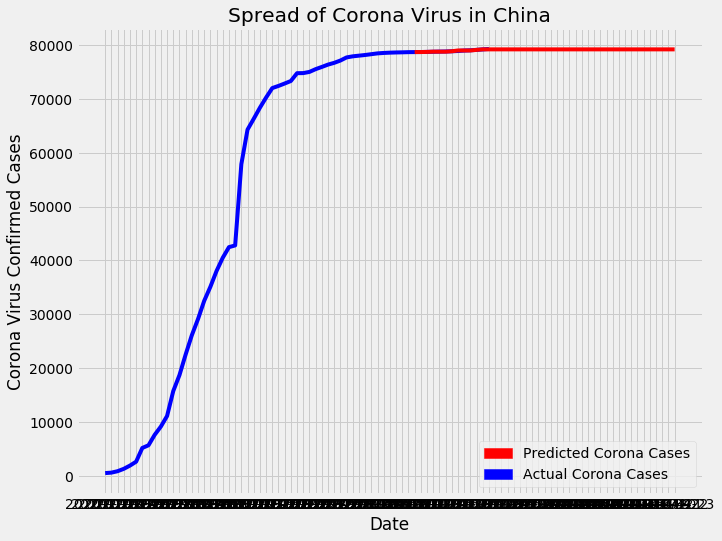

In [35]:
import matplotlib.patches as mpatches
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['ConfirmedCases'], 'b-')
plt.plot(test['Date'], test['ConfirmedCases'], 'r-')
red_patch = mpatches.Patch(color='red', label='Predicted Corona Cases')
blue_patch = mpatches.Patch(color='blue', label='Actual Corona Cases')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Date'); 
plt.ylabel('Corona Virus Confirmed Cases')
plt.title('Spread of Corona Virus in China');

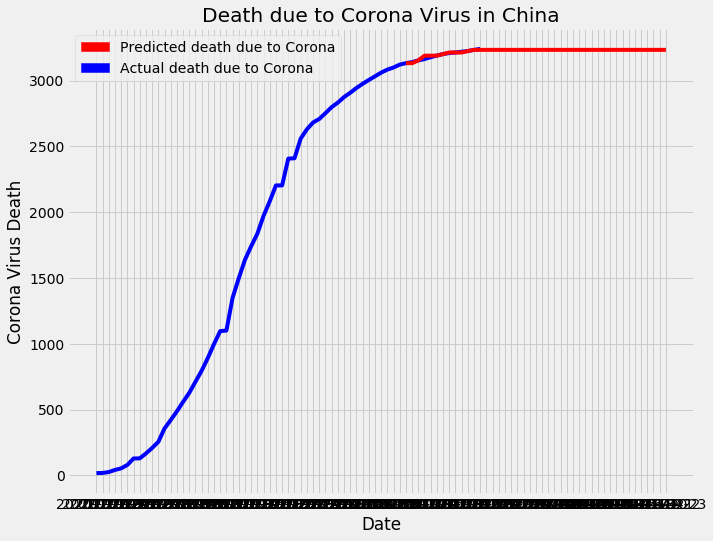

In [36]:
temp1 = pd.read_csv("../input/covid19-global-forecasting-week-1/train.csv")  
temp2 = pd.read_csv("../input/covid19-global-forecasting-week-1/test.csv")
train = train_df.loc[(train_df["Country/Region"]=="China")].groupby(["Date"])["Fatalities"].sum().reset_index()
test  = test_df.loc[(test_df["Country/Region"]=="China")].groupby(["Date"])["Death"].sum().reset_index()
train["Date"] = temp1["Date"]
test["Date"] = temp2["Date"]

import matplotlib.patches as mpatches
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Fatalities'], 'b-')
plt.plot(test['Date'], test['Death'], 'r-')
red_patch = mpatches.Patch(color='red', label='Predicted death due to Corona')
blue_patch = mpatches.Patch(color='blue', label='Actual death due to Corona')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Date'); 
plt.ylabel('Corona Virus Death')
plt.title('Death due to Corona Virus in China');

### Please stay tuned for more updates

### Please upvote if you find this kernel useful